# Exploratory Script for LWC calculation from GPR and Lidar in the Jemez Mountains for SnowEx20

## Objectives
1. Load GPR, probed depths, and snow pit data
2. Plot GPR and probed depths --> What are the spacings between measurements?
3. Match GPR to probed depths and invert for liquid water content (LWC)
4. Export site-wide average LWC to csv

In [1]:
#Load relevant packages
import os
import numpy as np 
from datetime import date
from scipy.spatial import cKDTree

#packages for figures
import matplotlib.pyplot as plt
from rasterio.plot import show

#geospatial packages
import geopandas as gpd #for vector data
#import xarray as xr
#import rioxarray #for raster data
import pandas as pd
#from shapely.geometry import box, Point
#import rasterio as rio

#Import SnowEx database
from snowexsql.api import PointMeasurements, LayerMeasurements, RasterMeasurements

## Part 1: Load data from github folder

In [2]:
#Part 1: Load GPR, probed depths, and snow pit data
#github_dataPath=r"https://github.com/snowex-hackweek/snowmelt-timing-2024/tree/main/Jemez_Data_2020/Jemez_SnowEx"

gpr_df = pd.read_csv("https://github.com/snowex-hackweek/snowmelt-timing-2024/raw/main/Jemez_Data_2020/Jemez_SnowEx/SNEX20_J_UNM_GPR.csv")

depth_df = pd.read_csv("https://github.com/snowex-hackweek/snowmelt-timing-2024/raw/main/Jemez_Data_2020/Jemez_SnowEx/UNM_SnowDepths_Manual_2020.csv")

sweTbl_df = pd.read_csv("https://github.com/snowex-hackweek/snowmelt-timing-2024/raw/main/Jemez_Data_2020/Jemez_SnowEx/SNEX20_TS_SP_Summary_SWE_v02.csv",skiprows=32)
sweTbl_df=sweTbl_df.drop(axis=0,index=0)

#Look at gpr headers
print(gpr_df.head())

   date_mmddyy Time_GMT  TWT_ns  depth_m  SWE_mm     Northing      Easting  \
0        21220    19:55    3.76     0.45     119  3969319.429  362649.0978   
1        21220    19:55    3.90     0.47     123  3969319.429  362649.0978   
2        21220    19:55    3.90     0.47     123  3969319.429  362649.0978   
3        21220    19:55    3.90     0.47     123  3969319.429  362649.0978   
4        21220    19:55    3.90     0.47     123  3969319.429  362649.0978   

   UTMZone  
0       13  
1       13  
2       13  
3       13  
4       13  


In [3]:
#Convert to geopandas
gpr_df = gpd.GeoDataFrame(gpr_df, geometry=gpd.points_from_xy(gpr_df.Easting, gpr_df.Northing), crs="EPSG:32613")
depth_df=gpd.GeoDataFrame(depth_df, geometry=gpd.points_from_xy(depth_df.Easting, depth_df.Northing), crs="EPSG:32613")


#Parse into dates
#Feb 12 dates --> There are not GPR - probe matches
#gpr_feb12_df=gpr_df[gpr_df['date_mmddyy'] == 21220]
#depth_feb12_df=depth_df[depth_df['Date'] == 2122020]

#Feb 20 dates
gpr_feb20_df=gpr_df[gpr_df['date_mmddyy'] == 22020]
depth_feb20_df=depth_df[depth_df['Date'] == 2202020]

#Feb 26 dates
gpr_feb26_df=gpr_df[gpr_df['date_mmddyy'] == 22620]
depth_feb26_df=depth_df[depth_df['Date'] == 2262020]

#Mar 4 dates
gpr_mar04_df=gpr_df[gpr_df['date_mmddyy'] == 30420]
depth_mar04_df=depth_df[depth_df['Date'] == 3042020]


## Part 2: Plot the GPR and probe data
### Identify regions of overlap

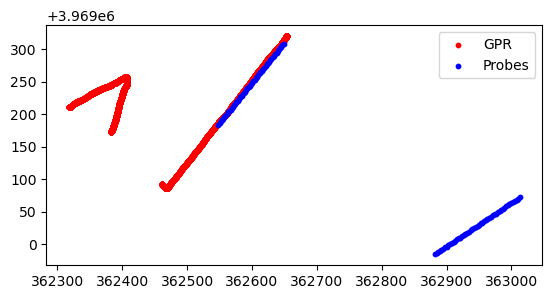

In [4]:
#Plot the Feb 20 Data
fig, ax = plt.subplots()
gpr_feb20_df.plot(ax=ax, color='red', markersize = 10)
depth_feb20_df.plot(ax=ax, color='blue', markersize = 10)
plt.legend(['GPR','Probes'])

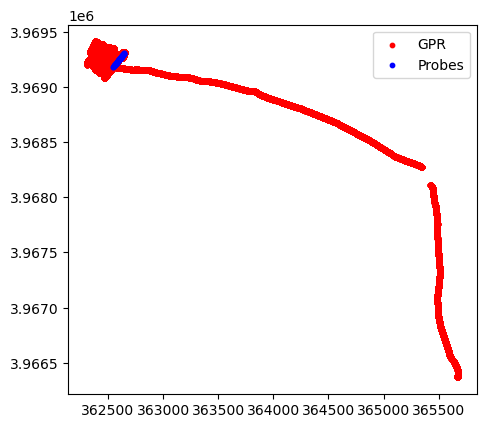

In [5]:
#Plot the Feb 26 Data
fig, ax = plt.subplots()
gpr_feb26_df.plot(ax=ax, color='red', markersize = 10)
depth_feb26_df.plot(ax=ax, color='blue', markersize = 10)
plt.legend(['GPR','Probes'])

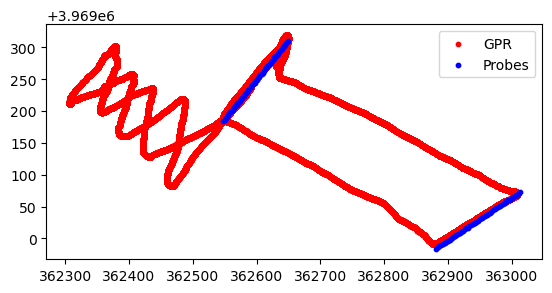

In [6]:
#Plot the Mar 4 Data
fig, ax = plt.subplots()
gpr_mar04_df.plot(ax=ax, color='red', markersize = 10)
depth_mar04_df.plot(ax=ax, color='blue', markersize = 10)
plt.legend(['GPR','Probes'])

## Part 3: Calculate LWC
### Workflow for each date:
1. Match GPR to probe coordinates
2. Run a nearest neighbor algorithm. Use a 1.5 m radius (half the probe sample distance)
3. Calculate median twt for each matched probe point
4. Invert for LWC, use the snow pit density (Equation modified by Bonnell et al., 2021 from Roth et al., 1990)
5. Calculate site-wide mean LWC and add to a dataframe
### Note, this code could be modified to export the point-wise derived measurements of LWC.

### LWC Calculations for Feb 20, 2020:

In [7]:
#Feb 20 gpr
gpr_feb20_arr = np.stack([gpr_feb20_df.geometry.x, gpr_feb20_df.geometry.y,gpr_feb20_df['TWT_ns']], axis=1)
gpr_feb20_x=gpr_feb20_arr[:,0].reshape(len(gpr_feb20_arr[:,0]),1)
gpr_feb20_y=gpr_feb20_arr[:,1].reshape(len(gpr_feb20_arr[:,1]),1)
gpr_feb20_twt=gpr_feb20_arr[:,2].reshape(len(gpr_feb20_arr[:,2]),1)

#Feb 20 depth
depth_feb20_arr = np.stack([depth_feb20_df.geometry.x, depth_feb20_df.geometry.y,depth_feb20_df['Depth']], axis=1)
depth_feb20_x=depth_feb20_arr[:,0].reshape(len(depth_feb20_arr[:,0]),1)
depth_feb20_y=depth_feb20_arr[:,1].reshape(len(depth_feb20_arr[:,1]),1)
depth_feb20_vec=depth_feb20_arr[:,2].reshape(len(depth_feb20_arr[:,2]),1)


In [8]:
#Create sets of coordinates for the nearest neighbors search
coordinates_set1 = np.column_stack((depth_feb20_x,depth_feb20_y))
coordinates_set2 = np.column_stack((gpr_feb20_x,gpr_feb20_y))

# Build KDTree from the second set of coordinates
tree = cKDTree(coordinates_set2)

# Define the radius (in meters)
radius = 1.5

# Function to find the median of travel times within a radius --> Credit where credit is due, this function was generated in part by chatgpt
def find_median_travel_time_within_radius(point, tree, coordinates_set1, gpr_feb20_twt, radius):
    indices = tree.query_ball_point(point, radius)
    if indices:
        # Retrieve travel times for the nearest neighbors
        neighbor_twt = gpr_feb20_twt[indices]
        median_twt = np.median(neighbor_twt)
        return median_twt
    else:
        return np.nan  # Return NaN if no neighbors are within the radius
# Find medians for each lidar point
medians = np.array([find_median_travel_time_within_radius(point, tree, coordinates_set2, gpr_feb20_twt, radius) for point in coordinates_set1])


In [9]:
#Before we get to the math part, let's clear out the nan's from all important vectors:
#Create mask for gpr medians that are nan's
mask = np.isnan(medians)

#Remove entries from the lidar snow depth, x, and y vectors that align with the nan twt values
depth_feb20_vec_clean = depth_feb20_vec[~mask]
coordinates_set1_clean=coordinates_set1[~mask]

#Lastly, remove entries from the twt medians
medians_clean = medians[~mask]

#Let's check the new size of the twt array
print(medians_clean.shape)

medians_clean=medians_clean.reshape(len(medians_clean),1)

(9,)


In [10]:
#We finally get to the math part!!

#Let's calculate relative permittivity first...
c=0.2998#The speed of light in a vacuum
e_s = ((c * medians_clean) / (2 * (depth_feb20_vec_clean / 100))) ** 2

#Note --> The follow code uses a revised Roth et al. (1990) formula for deriving LWC.
#Roth et al. is a three-phase mixing formula, requiring the densities/relative permittivities of air, ice, and water.

#Pull bulk density
feb20_rho_s = 303#From the SWE Summary table in Jemez data
#Set remaining necessary variables
e_i = 3.18  # relative permittivity of ice
e_a = 1.0  # Relative permittivity of air
e_w = 88  # Relative permittivity of water
rho_w = 1000  # Density of water
rho_i = 917  # Density of ice

# Calculate LWC_upper
LWC_upper = np.sqrt(e_s) - (feb20_rho_s / 917) * (np.sqrt(e_i) - np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC_lower
LWC_lower = np.sqrt(e_w) - (rho_w / rho_i) * (np.sqrt(e_i) + np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC
LWC = LWC_upper / LWC_lower


#And then use the density to estimate LWC
#Remove erroneous values --> NOTE THAT THIS IS SUBJECTIVE!!
LWC[LWC <0] = 0

LWC=LWC[(LWC <= 0.1)]

print(LWC)
#print(np.mean(LWC))

LWC_df = pd.DataFrame(columns=['Date','LWC'])
LWC_df.loc[0] = [2202020, np.mean(LWC)]
print(LWC_df.head())

[0.08250784 0.         0.00446337 0.         0.         0.08189603
 0.        ]
        Date       LWC
0  2202020.0  0.024124


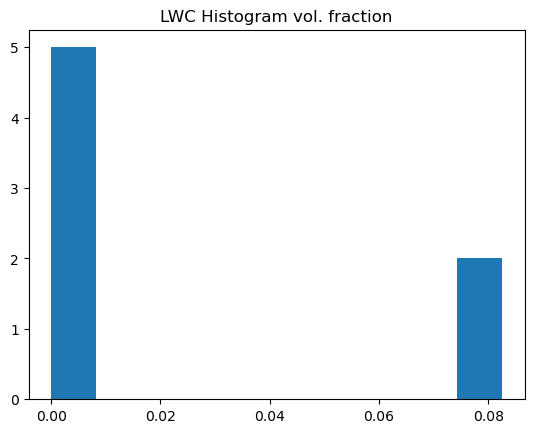

In [11]:
#What does the histogram distribution of the LWC look like??
# Create the histogram
plt.figure()  # Create a new figure
plt.hist(LWC, edgecolor=None)  # Plot histogram with specified bin edges

plt.title('LWC Histogram vol. fraction')

# Show the plot
plt.show()

In [12]:
### LWC Calculations for Feb 26, 2020:

In [13]:
#Feb 26 gpr
gpr_feb26_arr = np.stack([gpr_feb26_df.geometry.x, gpr_feb26_df.geometry.y,gpr_feb26_df['TWT_ns']], axis=1)
gpr_feb26_x=gpr_feb26_arr[:,0].reshape(len(gpr_feb26_arr[:,0]),1)
gpr_feb26_y=gpr_feb26_arr[:,1].reshape(len(gpr_feb26_arr[:,1]),1)
gpr_feb26_twt=gpr_feb26_arr[:,2].reshape(len(gpr_feb26_arr[:,2]),1)

#Feb 26 depth
depth_feb26_arr = np.stack([depth_feb26_df.geometry.x, depth_feb26_df.geometry.y,depth_feb26_df['Depth']], axis=1)
depth_feb26_x=depth_feb26_arr[:,0].reshape(len(depth_feb26_arr[:,0]),1)
depth_feb26_y=depth_feb26_arr[:,1].reshape(len(depth_feb26_arr[:,1]),1)
depth_feb26_vec=depth_feb26_arr[:,2].reshape(len(depth_feb26_arr[:,2]),1)
#print(depth_feb20_vec)

In [14]:
#Create sets of coordinates for the nearest neighbors search
coordinates_set1 = np.column_stack((depth_feb26_x,depth_feb26_y))
coordinates_set2 = np.column_stack((gpr_feb26_x,gpr_feb26_y))

# Build KDTree from the second set of coordinates
tree = cKDTree(coordinates_set2)

# Define the radius (in meters)
radius = 1.5

# Function to find the median of travel times within a radius --> Credit where credit is due, this function was generated in part by chatgpt
def find_median_travel_time_within_radius(point, tree, coordinates_set1, gpr_feb26_twt, radius):
    indices = tree.query_ball_point(point, radius)
    if indices:
        # Retrieve travel times for the nearest neighbors
        neighbor_twt = gpr_feb26_twt[indices]
        median_twt = np.median(neighbor_twt)
        return median_twt
    else:
        return np.nan  # Return NaN if no neighbors are within the radius
# Find medians for each lidar point
medians = np.array([find_median_travel_time_within_radius(point, tree, coordinates_set2, gpr_feb26_twt, radius) for point in coordinates_set1])


In [15]:
#Before we get to the math part, let's clear out the nan's from all important vectors:
#Create mask for gpr medians that are nan's
#Set medians to a single axis

mask = np.isnan(medians)

#Remove entries from the lidar snow depth, x, and y vectors that align with the nan twt values
depth_feb26_vec_clean = depth_feb26_vec[~mask]
coordinates_set1_clean=coordinates_set1[~mask]

#Lastly, remove entries from the twt medians
medians_clean = medians[~mask]

#Let's check the new size of the twt array
print(medians_clean.shape)

medians_clean=medians_clean.reshape(len(medians_clean),1)

(55,)


In [16]:
#We finally get to the math part!!

#Let's calculate relative permittivity first...
c=0.2998#The speed of light in a vacuum
e_s = ((c * medians_clean) / (2 * (depth_feb26_vec_clean / 100))) ** 2

#Note --> The follow code uses a revised Roth et al. (1990) formula for deriving LWC.
#Roth et al. is a three-phase mixing formula, requiring the densities/relative permittivities of air, ice, and water.

#Pull bulk density
feb26_rho_s = 309#From the SWE Summary table in Jemez data
#Set remaining necessary variables
e_i = 3.18  # relative permittivity of ice
e_a = 1.0  # Relative permittivity of air
e_w = 88  # Relative permittivity of water
rho_w = 1000  # Density of water
rho_i = 917  # Density of ice

# Calculate LWC_upper
LWC_upper = np.sqrt(e_s) - (feb26_rho_s / 917) * (np.sqrt(e_i) - np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC_lower
LWC_lower = np.sqrt(e_w) - (rho_w / rho_i) * (np.sqrt(e_i) + np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC
LWC = LWC_upper / LWC_lower


#And then use the density to estimate LWC
#Remove erroneous values
LWC[LWC <0] = 0

LWC=LWC[(LWC <= 0.1)]

print(LWC)
#print(np.mean(LWC))


LWC_df.loc[1] = [2242020, np.mean(LWC)]
print(LWC_df.head())

[0.08428318 0.05656363 0.01593213 0.02079265 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.05070353 0.05999728 0.02439747 0.01743435
 0.03443949 0.         0.         0.         0.         0.00817598
 0.         0.         0.         0.         0.         0.
 0.         0.00695886 0.         0.04503175 0.         0.
 0.         0.         0.         0.         0.         0.04475251
 0.         0.         0.         0.         0.         0.
 0.        ]
        Date       LWC
0  2202020.0  0.024124
1  2242020.0  0.008536


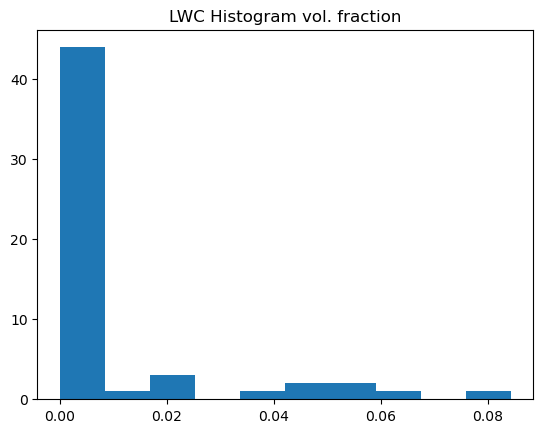

In [17]:
#What does the histogram distribution of the LWC look like??
# Create the histogram
plt.figure()  # Create a new figure
plt.hist(LWC, edgecolor=None)  # Plot histogram with specified bin edges

plt.title('LWC Histogram vol. fraction')

# Show the plot
plt.show()

### LWC Calculations for Mar 4, 2020:

In [18]:
#Mar 04 gpr
gpr_mar04_arr = np.stack([gpr_mar04_df.geometry.x, gpr_mar04_df.geometry.y,gpr_mar04_df['TWT_ns']], axis=1)
gpr_mar04_x=gpr_mar04_arr[:,0].reshape(len(gpr_mar04_arr[:,0]),1)
gpr_mar04_y=gpr_mar04_arr[:,1].reshape(len(gpr_mar04_arr[:,1]),1)
gpr_mar04_twt=gpr_mar04_arr[:,2].reshape(len(gpr_mar04_arr[:,2]),1)

#Feb 26 depth
depth_mar04_arr = np.stack([depth_mar04_df.geometry.x, depth_mar04_df.geometry.y,depth_mar04_df['Depth']], axis=1)
depth_mar04_x=depth_mar04_arr[:,0].reshape(len(depth_mar04_arr[:,0]),1)
depth_mar04_y=depth_mar04_arr[:,1].reshape(len(depth_mar04_arr[:,1]),1)
depth_mar04_vec=depth_mar04_arr[:,2].reshape(len(depth_mar04_arr[:,2]),1)
#print(depth_mar04_vec)

In [19]:
#Create sets of coordinates for the nearest neighbors search
coordinates_set1 = np.column_stack((depth_mar04_x,depth_mar04_y))
coordinates_set2 = np.column_stack((gpr_mar04_x,gpr_mar04_y))

# Build KDTree from the second set of coordinates
tree = cKDTree(coordinates_set2)

# Define the radius (in meters)
radius = 1.5

# Function to find the median of travel times within a radius --> Credit where credit is due, this function was generated in part by chatgpt
def find_median_travel_time_within_radius(point, tree, coordinates_set1, gpr_mar04_twt, radius):
    indices = tree.query_ball_point(point, radius)
    if indices:
        # Retrieve travel times for the nearest neighbors
        neighbor_twt = gpr_mar04_twt[indices]
        median_twt = np.median(neighbor_twt)
        return median_twt
    else:
        return np.nan  # Return NaN if no neighbors are within the radius
# Find medians for each lidar point
medians = np.array([find_median_travel_time_within_radius(point, tree, coordinates_set2, gpr_mar04_twt, radius) for point in coordinates_set1])


In [20]:
#Before we get to the math part, let's clear out the nan's from all important vectors:
#Create mask for gpr medians that are nan's
#Set medians to a single axis

mask = np.isnan(medians)

#Remove entries from the lidar snow depth, x, and y vectors that align with the nan twt values
depth_mar04_vec_clean = depth_mar04_vec[~mask]
coordinates_set1_clean=coordinates_set1[~mask]

#Lastly, remove entries from the twt medians
medians_clean = medians[~mask]

#Let's check the new size of the twt array
print(medians_clean.shape)

medians_clean=medians_clean.reshape(len(medians_clean),1)

(35,)


In [21]:
#We finally get to the math part!!

#NOTE REGARDING THIS CELL: Error code suggests a divide-by-zero error, probably need to address...

#Let's calculate relative permittivity first...
c=0.2998#The speed of light in a vacuum
e_s = ((c * medians_clean) / (2 * (depth_mar04_vec_clean / 100))) ** 2

#Note --> The follow code uses a revised Roth et al. (1990) formula for deriving LWC.
#Roth et al. is a three-phase mixing formula, requiring the densities/relative permittivities of air, ice, and water.

#Pull bulk density
mar04_rho_s = 340#From the SWE Summary table in Jemez data
#Set remaining necessary variables
e_i = 3.18  # relative permittivity of ice
e_a = 1.0  # Relative permittivity of air
e_w = 88  # Relative permittivity of water
rho_w = 1000  # Density of water
rho_i = 917  # Density of ice

# Calculate LWC_upper
LWC_upper = np.sqrt(e_s) - (mar04_rho_s / 917) * (np.sqrt(e_i) - np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC_lower
LWC_lower = np.sqrt(e_w) - (rho_w / rho_i) * (np.sqrt(e_i) + np.sqrt(e_a)) - np.sqrt(e_a)

# Calculate LWC
LWC = LWC_upper / LWC_lower


#And then use the density to estimate LWC
#Remove erroneous values --> NOTE, THIS IS SUBJECTIVE!!!
LWC[LWC <0] = 0

LWC=LWC[(LWC <= 0.1)]

print(LWC)
#print(np.mean(LWC))


LWC_df.loc[2] = [2242020, np.mean(LWC)]
print(LWC_df.head())

[0.08603096 0.0745612  0.         0.         0.02850474 0.00221587
 0.00061568 0.07216019 0.05046578 0.00235069 0.03501436 0.
 0.         0.03814399 0.         0.         0.         0.04587486
 0.         0.         0.         0.         0.         0.
 0.        ]
        Date       LWC
0  2202020.0  0.024124
1  2242020.0  0.008536
2  2242020.0  0.017438


/tmp/ipykernel_265/1936693741.py:5: RuntimeWarning: divide by zero encountered in divide
  e_s = ((c * medians_clean) / (2 * (depth_mar04_vec_clean / 100))) ** 2


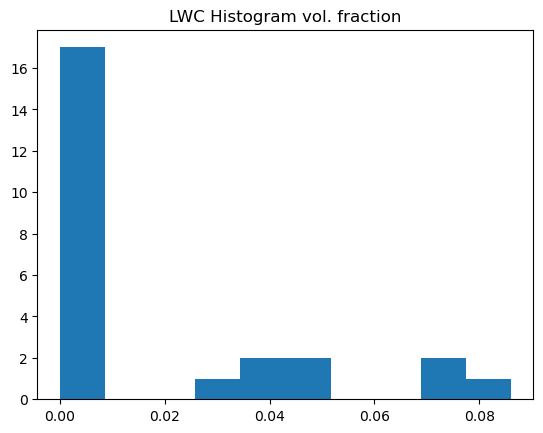

In [22]:
#What does the histogram distribution of the LWC look like??
# Create the histogram
plt.figure()  # Create a new figure
plt.hist(LWC, edgecolor=None)  # Plot histogram with specified bin edges

plt.title('LWC Histogram vol. fraction')

# Show the plot
plt.show()

## Part 5: Export site-wide volumetric fractional LWC to csv

In [23]:
#LWC_df.to_csv('Jemez_FieldSiteAverageLWC_2020.csv')